# Lecture 13 - De novo Molecule Generation

```{contents}
:local:
:depth: 1
```

## 1. Setup and data

We keep code in small steps. After each step we print a small result so you can see shapes and objects.

In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

RDKit is assumed in this course. If it is not present in your environment, you can still read, but some cells will not run.

In [2]:
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, Draw
    RD = True
except Exception:
    RD = False
    Chem = None
RD

True

For ML we only need a few pieces. We will add more as needed.

In [3]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Load the small C-H oxidation dataset used in earlier lectures.

In [4]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"


Compute 10 quick descriptors that we will reuse several times today.

In [5]:
def calc_descriptors10(smiles: str):
    if not RD:
        return pd.Series({k: np.nan for k in [
            "MolWt","LogP","TPSA","NumRings","NumHAcceptors","NumHDonors",
            "NumRotatableBonds","HeavyAtomCount","FractionCSP3","NumAromaticRings"
        ]})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({k: np.nan for k in [
            "MolWt","LogP","TPSA","NumRings","NumHAcceptors","NumHDonors",
            "NumRotatableBonds","HeavyAtomCount","FractionCSP3","NumAromaticRings"
        ]})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
        "NumHAcceptors": rdMolDescriptors.CalcNumHBA(m),
        "NumHDonors": rdMolDescriptors.CalcNumHBD(m),
        "NumRotatableBonds": rdMolDescriptors.CalcNumRotatableBonds(m),
        "HeavyAtomCount": Descriptors.HeavyAtomCount(m),
        "FractionCSP3": rdMolDescriptors.CalcFractionCSP3(m),
        "NumAromaticRings": rdMolDescriptors.CalcNumAromaticRings(m),
    })

desc10 = df_raw["SMILES"].apply(calc_descriptors10)
df10 = pd.concat([df_raw, desc10], axis=1).dropna()
df10.shape, df10.head(2)

((575, 19),
                 Compound Name       CAS                  SMILES  \
 0  3,4-dihydro-1H-isochromene  493-05-0        c1ccc2c(c1)CCOC2   
 1                 9H-fluorene   86-73-7  c1ccc2c(c1)Cc1ccccc1-2   
 
    Solubility_mol_per_L   pKa   Toxicity  Melting Point  Reactivity  \
 0              0.103906  5.80  non_toxic           65.8           1   
 1              0.010460  5.82      toxic           90.0           1   
 
   Oxidation Site    MolWt    LogP  TPSA  NumRings  NumHAcceptors  NumHDonors  \
 0           8,10  134.178  1.7593  9.23       2.0            1.0         0.0   
 1              7  166.223  3.2578  0.00       3.0            0.0         0.0   
 
    NumRotatableBonds  HeavyAtomCount  FractionCSP3  NumAromaticRings  
 0                0.0            10.0      0.333333               1.0  
 1                0.0            13.0      0.076923               2.0  )

We pick a medium sized subset for quick AE experiments.

In [6]:
mask = (
    (df10["MolWt"].between(120, 450)) &
    ((df10["NumRings"] >= 1) | (df10["NumHAcceptors"] >= 1) | (df10["NumHDonors"] >= 1))
)
df_small = df10[mask].copy().sample(min(500, mask.sum()), random_state=42)
df_small.shape

(500, 19)

```{admonition} ⏰ Exercise 1
Change the MolWt range to 100..380 and re-run the filter. How many rows remain Print `df_small.shape`.
```

## 2. Unsupervised recap with a tiny PCA

We standardize 10D descriptors and compute a 2D PCA for a quick map. This connects to our earlier lecture on dimension reduction.

In [7]:
from sklearn.decomposition import PCA

feat_cols = ["MolWt","LogP","TPSA","NumRings","NumHAcceptors","NumHDonors",
             "NumRotatableBonds","HeavyAtomCount","FractionCSP3","NumAromaticRings"]
X = df_small[feat_cols].to_numpy(dtype=float)
scaler = StandardScaler().fit(X)
Xz = scaler.transform(X)

pca = PCA(n_components=2).fit(Xz)
Zp = pca.transform(Xz)
Zp[:3]

array([[ 4.49600188,  1.26404954],
       [ 0.43883249,  0.69197567],
       [ 0.45086122, -3.45685118]])

Plot the PCA map and color by number of rings.

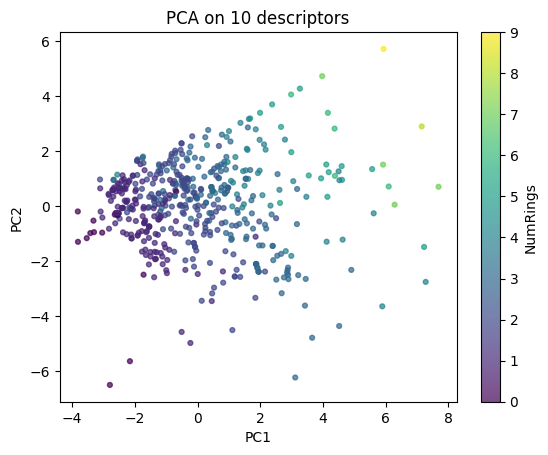

In [8]:
plt.scatter(Zp[:,0], Zp[:,1], c=df_small["NumRings"], cmap="viridis", s=12, alpha=0.7)
plt.colorbar(label="NumRings")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA on 10 descriptors")
plt.show()

Look at loadings to see which descriptors drive PC1.

In [9]:
loadings = pd.Series(pca.components_[0], index=feat_cols).sort_values()
loadings

FractionCSP3        -0.237596
NumRotatableBonds   -0.022847
LogP                 0.165198
NumHDonors           0.251924
NumHAcceptors        0.293134
TPSA                 0.299482
NumAromaticRings     0.379889
NumRings             0.404603
MolWt                0.418982
HeavyAtomCount       0.439418
dtype: float64

```{admonition} ⏰ Exercise 2
Replace color by `TPSA` in the PCA scatter. What region corresponds to high TPSA
```

## 3. Autoencoder on descriptors

We build a very small autoencoder. The encoder compresses 10 numbers to 2. The decoder reconstructs the 10 numbers.

In [10]:
class TinyAE(nn.Module):
    def __init__(self, in_dim=10, hid=64, z_dim=2):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_dim, hid), nn.ReLU(), nn.Linear(hid, z_dim))
        self.dec = nn.Sequential(nn.Linear(z_dim, hid), nn.ReLU(), nn.Linear(hid, in_dim))
    def encode(self, x): return self.enc(x)
    def decode(self, z): return self.dec(z)
    def forward(self, x):
        z = self.enc(x)
        xr = self.dec(z)
        return xr, z

ae = TinyAE(in_dim=10, hid=64, z_dim=2)
ae

TinyAE(
  (enc): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

Prepare tensors and a simple loader.

In [11]:
class ArrayDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X.astype(np.float32))
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i]

ds = ArrayDataset(Xz)
dl = DataLoader(ds, batch_size=64, shuffle=True)
xb = next(iter(dl))
xb.shape, xb[0,:4]

(torch.Size([64, 10]), tensor([-1.4587, -1.2725, -0.5686, -1.0040]))

Train for a few epochs and watch the loss.

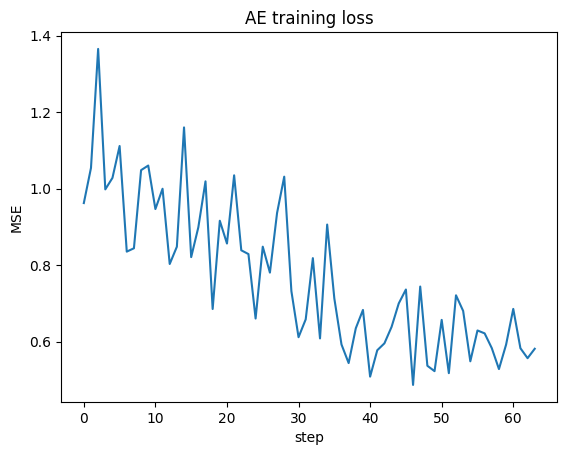

In [12]:
opt = optim.Adam(ae.parameters(), lr=1e-3)
losses = []
for ep in range(8):
    for xb in dl:
        xr, z = ae(xb)
        loss = nn.functional.mse_loss(xr, xb)
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
plt.plot(losses); plt.xlabel("step"); plt.ylabel("MSE"); plt.title("AE training loss"); plt.show()

Encode all rows to see the latent space. This is what **encode** returns.

In [13]:
with torch.no_grad():
    Z = ae.encode(torch.from_numpy(Xz.astype(np.float32))).numpy()
Z[:3]

array([[ 0.3566122 , -2.3071775 ],
       [-0.09010807, -0.19626446],
       [-0.24562994, -0.8618359 ]], dtype=float32)

Plot the latent and color by LogP.

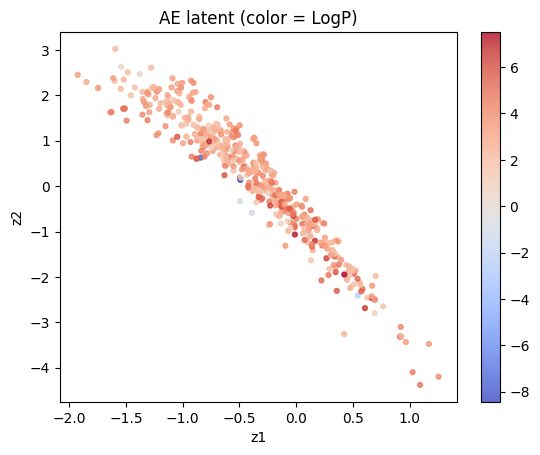

In [14]:
plt.scatter(Z[:,0], Z[:,1], c=df_small["LogP"], cmap="coolwarm", s=12, alpha=0.8)
plt.xlabel("z1"); plt.ylabel("z2"); plt.title("AE latent (color = LogP)")
plt.colorbar(); plt.show()

```{admonition} ⏰ Exercise 3
Change `z_dim` to 3 in `TinyAE` and plot `z[:,0]` vs `z[:,2]`. Does it reveal more structure
```

## 4. Why AE is tricky for SMILES

A descriptor AE reconstructs numbers. A molecular generator must produce valid SMILES. Small mistakes create invalid molecules. Here is a tiny example of parsing errors and a safe parser that skips them.

In [15]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

bad_smiles = ["C1CC1C1", "CCC(C)(C)(C)", "C=O=O", "C(C)(C)(C)(C)C"]
def safe_mol_from_smiles(smi):
    try:
        m = Chem.MolFromSmiles(smi, sanitize=False)
        if m is None: return None
        Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

parsed = [safe_mol_from_smiles(s) is not None for s in bad_smiles]
pd.DataFrame({"SMILES": bad_smiles, "is_valid": parsed})

,SMILES,is_valid
0,C1CC1C1,False
1,CCC(C)(C)(C),True
2,C=O=O,False
3,C(C)(C)(C)(C)C,False


This motivates a VAE which gives a distribution in latent space so we can sample smoothly and then decode to strings.

## 5. VAE concept with a tiny numeric example

The VAE encoder outputs a mean and a log-variance. We compute the KL term to the standard normal. For a single sample with diagonal covariance, the KL has a closed form.

In [16]:
mu = torch.tensor([0.2, -0.1])
logvar = torch.tensor([np.log(0.5), np.log(1.2)])
kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
float(kl)

0.06520640682625409

Reparameterization trick: sample epsilon and form z.

In [17]:
std = torch.exp(0.5*logvar)
eps = torch.randn_like(std)
z = mu + std * eps
z.numpy()

array([ 0.68454375, -1.1998065 ])

## 6. Build SMILES vocabulary and dataset

We fetch about 4k sanitized SMILES from QM9 using DeepChem, then tokenize to characters.

In [18]:
import deepchem as dc
tasks, datasets, transformers = dc.molnet.load_qm9(featurizer='Raw')
train_dataset, valid_dataset, test_dataset = datasets

def canonicalize_smiles(smi):
    if not smi: return None
    try:
        m = Chem.MolFromSmiles(smi, sanitize=False)
        if m is None: return None
        Chem.SanitizeMol(m)
        return Chem.MolToSmiles(m, canonical=True)
    except Exception:
        return None

def dataset_to_smiles(ds, max_n=None):
    out = []
    n = len(ds.X) if max_n is None else min(len(ds.X), max_n)
    for i in range(n):
        mol = ds.X[i]
        if mol is None: continue
        try:
            s = Chem.MolToSmiles(mol, canonical=True)
        except Exception:
            continue
        can = canonicalize_smiles(s)
        if can: out.append(can)
    return out

pool_smiles = list(dict.fromkeys(dataset_to_smiles(train_dataset, max_n=10000)))
len(pool_smiles)

ModuleNotFoundError: No module named 'tensorflow'

Select ~4k and split.

In [ ]:
rng = np.random.default_rng(42)
target_n = 4000
if len(pool_smiles) > target_n:
    smiles_all = rng.choice(pool_smiles, size=target_n, replace=False).tolist()
else:
    smiles_all = pool_smiles[:target_n]

train_smiles, val_smiles = train_test_split(smiles_all, test_size=0.1, random_state=42)
len(train_smiles), len(val_smiles)

Build the character vocabulary and a simple dataset.

In [ ]:
SPECIAL = ["[PAD]", "[SOS]", "[EOS]"]
chars = set()
for s in train_smiles:
    for ch in s: chars.add(ch)
idx2ch = SPECIAL + sorted(chars)
ch2idx = {c:i for i,c in enumerate(idx2ch)}
PAD, SOS, EOS = ch2idx["[PAD]"], ch2idx["[SOS]"], ch2idx["[EOS]"]
vocab_size = len(idx2ch); vocab_size

In [ ]:
MAX_LEN = 120

def smiles_to_idx(s):
    toks = [SOS] + [ch2idx.get(ch, None) for ch in s] + [EOS]
    toks = [t for t in toks if t is not None]
    toks = toks[:MAX_LEN]
    attn = [1]*len(toks)
    if len(toks) < MAX_LEN:
        toks += [PAD]*(MAX_LEN - len(toks))
        attn += [0]*(MAX_LEN - len(attn))
    return np.array(toks, np.int64), np.array(attn, np.int64)

class SmilesDataset(Dataset):
    def __init__(self, smiles_list):
        pairs = [smiles_to_idx(s) for s in smiles_list]
        self.toks = np.stack([p[0] for p in pairs])
        self.attn = np.stack([p[1] for p in pairs])
    def __len__(self): return len(self.toks)
    def __getitem__(self, i):
        return torch.from_numpy(self.toks[i]), torch.from_numpy(self.attn[i])

train_ds = SmilesDataset(train_smiles)
val_ds   = SmilesDataset(val_smiles)
(train_ds[0][0][:20].numpy(), train_ds[0][1][:20].numpy().sum())

```{admonition} ⏰ Exercise 4
Print the full `idx2ch` list and count vowels or special punctuation. What characters are most frequent in your SMILES
```

## 7. SMILES VAE model and training

We use a compact GRU-based VAE. The loss is cross entropy for next character plus a small KL term.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid_dim=256, z_dim=64):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.mu = nn.Linear(hid_dim, z_dim)
        self.logvar = nn.Linear(hid_dim, z_dim)
    def forward(self, x, attn):
        emb = self.emb(x)
        lengths = attn.sum(1).cpu()
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
        _, h = self.gru(packed)
        h = h[-1]
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid_dim=256, z_dim=64):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.fc_z = nn.Linear(z_dim, hid_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.out = nn.Linear(hid_dim, vocab_size)
    def forward(self, z, x_in):
        h0 = self.fc_z(z).unsqueeze(0)
        emb = self.emb(x_in)
        o, _ = self.gru(emb, h0)
        return self.out(o)

class VAE(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid_dim=256, z_dim=64):
        super().__init__()
        self.enc = Encoder(vocab_size, emb_dim, hid_dim, z_dim)
        self.dec = Decoder(vocab_size, emb_dim, hid_dim, z_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x, attn):
        mu, logvar = self.enc(x, attn)
        z = self.reparameterize(mu, logvar)
        logits = self.dec(z, x[:, :-1])
        return logits, mu, logvar

def vae_loss(logits, x, mu, logvar, kl_weight=0.1):
    targets = x[:, 1:]
    ce = nn.functional.cross_entropy(
        logits.reshape(-1, logits.size(-1)),
        targets.reshape(-1),
        ignore_index=PAD
    )
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return ce + kl_weight*kl, ce.item(), kl.item()

model = VAE(vocab_size)
opt = optim.Adam(model.parameters(), lr=2e-3)

Train 30 epochs and plot loss.

In [ ]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False, drop_last=False)

EPOCHS = 30
hist = {"train": [], "val": [], "ce": [], "kl": []}

for ep in range(1, EPOCHS+1):
    model.train()
    tr_losses, ce_losses, kl_losses = [], [], []
    for x, a in train_loader:
        logits, mu, logvar = model(x, a)
        loss, ce, kl = vae_loss(logits, x, mu, logvar, kl_weight=0.1)
        opt.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        tr_losses.append(loss.item()); ce_losses.append(ce); kl_losses.append(kl)
    model.eval()
    with torch.no_grad():
        val_losses = []
        for x, a in val_loader:
            logits, mu, logvar = model(x, a)
            l, _, _ = vae_loss(logits, x, mu, logvar, kl_weight=0.1)
            val_losses.append(l.item())
    hist["train"].append(np.mean(tr_losses))
    hist["val"].append(np.mean(val_losses) if len(val_losses)>0 else np.nan)
    hist["ce"].append(np.mean(ce_losses)); hist["kl"].append(np.mean(kl_losses))
    print(f"Epoch {ep:02d} | train {hist['train'][-1]:.3f} | val {hist['val'][-1]:.3f} | CE {hist['ce'][-1]:.3f} | KL {hist['kl'][-1]:.3f}")

plt.plot(hist["train"], label="train"); plt.plot(hist["val"], label="val")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("VAE loss over epochs"); plt.legend(); plt.show()

```{admonition} ⏰ Exercise 5
Set `kl_weight=0.2` and train for 5 epochs. Does CE go up while KL goes down What happens to the validation curve
```

## 8. Sampling and evaluation

Sample strings from the decoder by drawing z from the prior.

In [ ]:
def sample_smiles(n=1500, max_len=120, temp=1.0):
    model.eval()
    out = []
    with torch.no_grad():
        z = torch.randn(n, model.enc.mu.out_features)
        x_t = torch.full((n,1), SOS, dtype=torch.long)
        h = model.dec.fc_z(z).unsqueeze(0)
        for t in range(max_len-1):
            emb = model.dec.emb(x_t[:,-1:])
            o, h = model.dec.gru(emb, h)
            logits = model.dec.out(o[:, -1])
            probs = nn.functional.softmax(logits / temp, dim=-1)
            nxt = torch.multinomial(probs, num_samples=1)
            x_t = torch.cat([x_t, nxt], dim=1)
        seqs = x_t[:, 1:].tolist()
    for seq in seqs:
        chars = []
        for idx in seq:
            ch = idx2ch[idx]
            if ch == "[EOS]": break
            if ch not in ("[PAD]","[SOS]"): chars.append(ch)
        out.append("".join(chars))
    return out

gen_raw = sample_smiles(n=2000, temp=1.0)
gen_raw[:5]

Filter to valid canonical SMILES and compute metrics.

In [ ]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def safe_mol_from_smiles(smi):
    try:
        m = Chem.MolFromSmiles(smi, sanitize=False)
        if m is None: return None
        Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

def canonicalize_batch(smiles_list):
    out = []
    for s in smiles_list:
        m = safe_mol_from_smiles(s)
        if m is None: continue
        can = Chem.MolToSmiles(m, canonical=True)
        if can: out.append(can)
    return out

gen_smiles = canonicalize_batch(gen_raw)
train_set = set(train_smiles)

validity   = len(gen_smiles) / max(1, len(gen_raw))
uniq_list  = list(dict.fromkeys(gen_smiles))
uniqueness = len(uniq_list) / max(1, len(gen_smiles))
novelty    = sum(1 for s in uniq_list if s not in train_set) / max(1, len(uniq_list))

print(f"Validity: {validity:.2f}  Uniqueness: {uniqueness:.2f}  Novelty: {novelty:.2f}")

Compare property distributions.

In [ ]:
from rdkit.Chem import QED, Crippen, Descriptors

def props_from_smiles(smiles):
    rows = []
    for s in smiles:
        m = safe_mol_from_smiles(s)
        if m is None: continue
        rows.append({"SMILES": s, "QED": QED.qed(m), "logP": Crippen.MolLogP(m), "MW": Descriptors.MolWt(m)})
    return pd.DataFrame(rows)

rng = np.random.default_rng(0)
train_unique = list(set(train_smiles))
gen_unique   = list(set(gen_smiles))
train_sample = rng.choice(train_unique, size=min(3000, len(train_unique)), replace=False)
gen_sample   = rng.choice(gen_unique, size=min(3000, len(gen_unique)), replace=False)

df_train = props_from_smiles(train_sample)
df_gen   = props_from_smiles(gen_sample)

def plot_dist(metric, bins=40):
    plt.figure(figsize=(6,4))
    plt.hist(df_train[metric].dropna(), bins=bins, alpha=0.5, density=True, label="Train")
    plt.hist(df_gen[metric].dropna(),   bins=bins, alpha=0.5, density=True, label="Generated")
    plt.xlabel(metric); plt.ylabel("Density"); plt.title(f"{metric} distribution"); plt.legend(); plt.show()

for m in ["QED","logP","MW"]:
    plot_dist(m)

```{admonition} ⏰ Exercise 6
Run `sample_smiles` with temperatures 0.7 and 1.3. Which one increases validity Which one increases uniqueness How do the histograms shift
```

## 9. Glossary

```{glossary}
encoder
  A mapping from input $x$ to latent $z$.

decoder
  A mapping from latent $z$ to reconstructed $\hat x$.

autoencoder (AE)
  A model trained to reconstruct input. Learns a compact latent code.

latent space
  The internal coordinate used by the model to organize inputs.

VAE
  A probabilistic AE that learns $q_\theta(z\mid x)$ near a simple prior to enable sampling.

validity
  Fraction of generated strings that sanitize as molecules.

uniqueness
  Fraction of valid generated molecules that are unique.

novelty
  Fraction of unique generated molecules not present in the training set.
```

## 10. In-class activity with solutions

**Q1.** AE latent: change `z_dim` to 3 and plot `z[:,0]` vs `z[:,1]`. Compare to `z[:,1]` vs `z[:,2]`.

In [ ]:
ae3 = TinyAE(in_dim=10, hid=64, z_dim=3)
opt = optim.Adam(ae3.parameters(), lr=1e-3)
for ep in range(4):
    for xb in dl:
        xr, z = ae3(xb)
        loss = nn.functional.mse_loss(xr, xb)
        opt.zero_grad(); loss.backward(); opt.step()
with torch.no_grad():
    Z3 = ae3.encode(torch.from_numpy(Xz.astype(np.float32))).numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.scatter(Z3[:,0], Z3[:,1], s=10, alpha=0.7); plt.xlabel("z0"); plt.ylabel("z1"); plt.title("z0 vs z1")
plt.subplot(1,2,2); plt.scatter(Z3[:,1], Z3[:,2], s=10, alpha=0.7); plt.xlabel("z1"); plt.ylabel("z2"); plt.title("z1 vs z2")
plt.tight_layout(); plt.show()

**Q2.** VAE temperature sweep: compute validity for T in [0.7, 1.0, 1.3].

In [ ]:
for t in [0.7, 1.0, 1.3]:
    raw = sample_smiles(n=800, temp=t)
    val = len(canonicalize_batch(raw)) / max(1, len(raw))
    print(f"T={t}: validity {val:.2f}")

**Q3.** Wasserstein distance for QED.

In [ ]:
try:
    from scipy.stats import wasserstein_distance
    a = df_train["QED"].dropna().values; b = df_gen["QED"].dropna().values
    print("QED W-dist:", round(wasserstein_distance(a,b), 4))
except Exception as e:
    print("SciPy not available")

**Q4.** Show 12 novel molecules with QED.

In [ ]:
uniq = list(dict.fromkeys(gen_smiles))
novel_only = [s for s in uniq if s not in train_set][:12]
mols = [Chem.MolFromSmiles(s) for s in novel_only]
qed_vals = [QED.qed(m) for m in mols]
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(220,220),
                           legends=[f"QED={q:.2f}" for q in qed_vals])
display(img)

**Q5.** AE loss: swap MSE for MAE and compare curves in one figure.

In [ ]:
# MSE run
ae_mse = TinyAE(in_dim=10, hid=64, z_dim=2)
opt_mse = optim.Adam(ae_mse.parameters(), lr=1e-3)
loss_mse = []
for ep in range(4):
    for xb in dl:
        xr, _ = ae_mse(xb)
        l = nn.functional.mse_loss(xr, xb)
        opt_mse.zero_grad(); l.backward(); opt_mse.step()
        loss_mse.append(float(l))

# MAE run
ae_mae = TinyAE(in_dim=10, hid=64, z_dim=2)
opt_mae = optim.Adam(ae_mae.parameters(), lr=1e-3)
loss_mae = []
for ep in range(4):
    for xb in dl:
        xr, _ = ae_mae(xb)
        l = nn.functional.l1_loss(xr, xb)
        opt_mae.zero_grad(); l.backward(); opt_mae.step()
        loss_mae.append(float(l))

plt.plot(loss_mse, label="MSE"); plt.plot(loss_mae, label="MAE")
plt.xlabel("step"); plt.ylabel("loss"); plt.title("AE: MSE vs MAE"); plt.legend(); plt.show()